# Dynamic Aperture for HL-LHC

## Introduction

One strategic upgrade for HL-LHC is the installation of additional collimators (TCLD) in the dispersion suppressor region of the collimation insertion IR7. This is typically the location in which the highest collimation losses are observed and simulated (particles scattered out of the LHC collimation system). The concerned area is equipped with the superconducing LHC dipoles, hence the required space for the installation of the TCLD collimators is not available. Therefore, the proposed solution includes the replacement of the 15m long main dipoles (MB) with a nominal magnetic field of 8.3T by shorter dipoles (MBH) with a nominal magnetic field of 11T and 5.5m length. 

<img src="deps/tcld.png">

The nominal baseline is to replace the MB.B8R7 on the right hand side by two MBH units MBH.A8R7/MBH.B8R7 and equivalently the MBH.B8L7 at the left hand side of IR7. In between the two new magnets the TCLD collimator is supposed to be installed. A commonly studied scenario, which is not the present HL-LHC baseline, also includes the replacement of the MBH.A10R7/MBH.A10L7 in addition. Furthermore, the collimation simulations, in paricular for heavy-ions, show that a shifing of the TCLD collimators could be advantageous (see [[1]]). 

Magnetic field errors of the MBH dipoles may affect the dynamic aperture (DA) or introduce $\beta$-beating. This notebook analyzes these effects that were studied by means of dynamic aperture simulations using SixTrack via BOINC and optics simulations using MAD-X. The errortable used for the simulations can be found in:
    
    /afs/cern.ch/eng/lhc/optics/HLLHCV1.0/errors2/MBH_errortable_v2

[1]: https://indico.cern.ch/event/646799/contributions/2627224/attachments/1478327/2291048/colUSM170616_PH.pdf

## Initialization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import sixdesk.da as da

sixdbdir = '/home/phermes/development/SixDeskDB/'

## Dynamic Aperture at Injection/Collision

Define the names of the studies to be analyzed:

In [48]:
studies_template = 'HLLHC_{0}_B_{1}_MBH10M_{2}'
studies          = []
for _mode in ['inj','col']:
    for _beam in ['1','4']:
        for _mbh in ['-1','0','1']:
            studies.append(studies_template.format(_mode,_beam,_mbh))

Load the data from the studies into a dictionary

In [39]:
data = {}
for _study in studies:
    data[_study] = da.davsang(_study, directory = '/home/phermes/development/SixDeskDB/')

Plot and compare the data

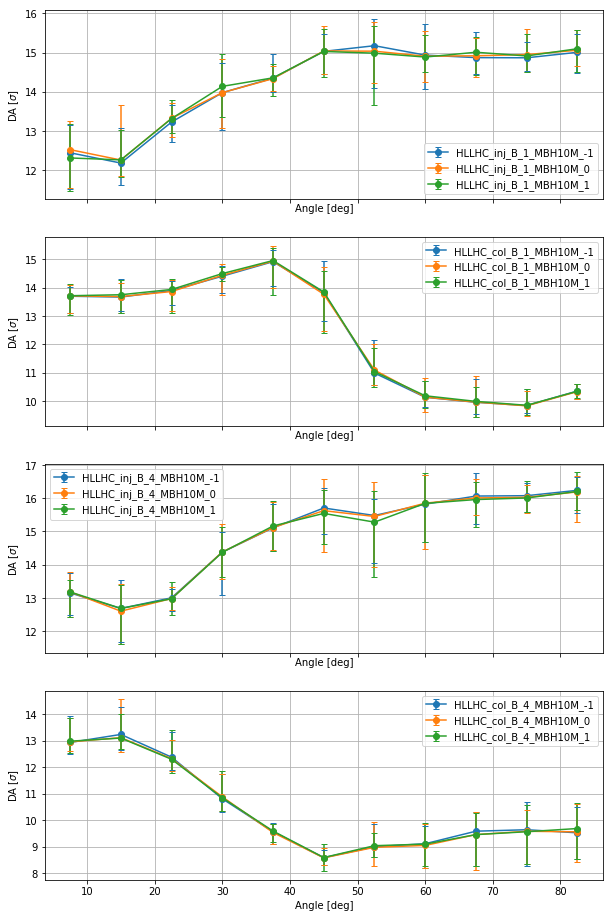

In [43]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True,figsize=[10,16])

for _key in data.keys():
    if 'inj' in _key and 'B_1' in _key:
        ax = ax1
    elif 'col' in _key and 'B_1' in _key:
        ax = ax2
    if 'inj' in _key and 'B_4' in _key:
        ax = ax3
    elif 'col' in _key and 'B_4' in _key:
        ax = ax4
    data[_key].plotDA(axis=ax,label=_key)
    
for ax in fig.get_axes():
    ax.grid()
    ax.legend()


plt.show()

### Conclusions
No significant change observed in the DA.

## Dynamic Aperture During Ramp

The individual field error components change during the ramp. Consider, for example, $b_3$, which is decreasing from roughly -2 to -15. The (absolute maximum) is reached at an early time of the ramp, but not at injection energy. The same applies for the remaining odd $b$ fields.

<img src="deps/fieldquality_full.png">

To study the impact of these field quality errors on dynamic aperture without simulating different steps during the ramp, the DA is simulated at injection energy. The odd $b$ fields are individually set to their (absolute) maximum while maintining the remaining field errors at their injection values. In addition, one simulation is carried out with all $b$ fields at their maximum at the same time. This approach overestimates the effects, because emittance shrinking from adiabatic damping is ignored. 

In [69]:
studies_template = 'HLLHC_ramp_B_{0}_MBH10_{1}_ERR_{2}'
studies          = []

# _beam -    1: Beam 1, 4: Beam 4
# _mbh  -   -1: no MBH magnets; 0: MBH magnets in cell 8R7/8L7; 1: MBH mag. in cells 8 and 10
# _err  -    0: all field errors set to max., !=0: only _err set to max

for _beam in ['1','4']:                      
    for _mbh in ['0', '1']:                  
        for _err in ['0','3','5','7','9']:   
            studies.append(studies_template.format(_beam,_mbh,_err))
            
# manually plug in the reference cases:

studies.append('HLLHC_inj_B_1_MBH10M_-1')
studies.append('HLLHC_inj_B_4_MBH10M_-1')

In [70]:
# read the DA data

data = {}
for _study in studies:
    data[_study] = da.davsang(_study, directory = '/home/phermes/development/SixDeskDB/')

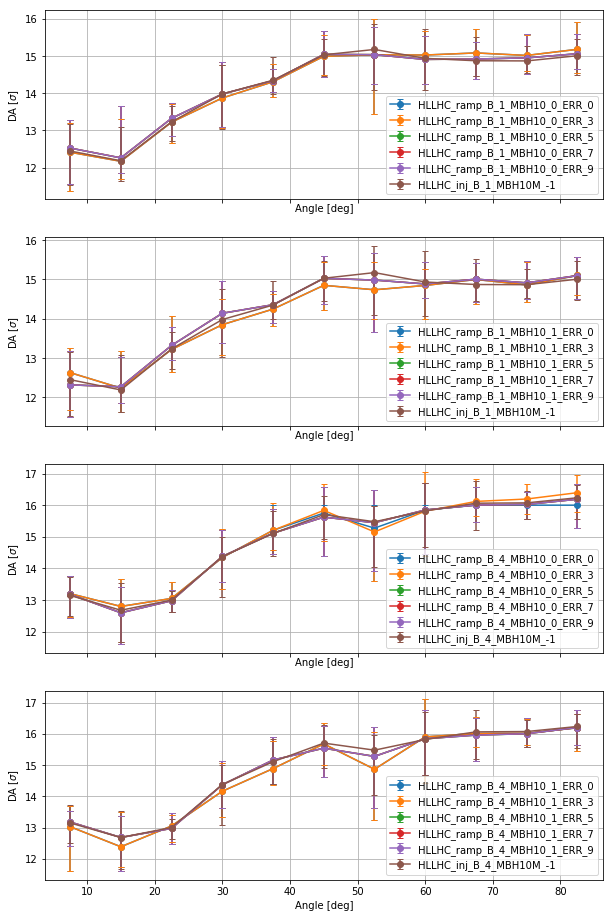

In [80]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True,figsize=[10,16])

for _key in data.keys():
    if 'MBH10_0' in _key and 'B_1' in _key:
        ax = [ax1]
    elif 'MBH10_1' in _key and 'B_1' in _key:
        ax = [ax2]
    elif 'MBH10_0' in _key and 'B_4' in _key:
        ax = [ax3]
    elif 'MBH10_1' in _key and 'B_4' in _key:
        ax = [ax4]
    elif 'inj_B_1' in _key:                          # plot the reference for both cases [MBH10_0 and MBH10_1]
        ax = [ax1, ax2]
    elif 'inj_B_4' in _key:
        ax = [ax3, ax4]
        
    for axis in ax:
        data[_key].plotDA(axis=axis,label=_key)
    
    
for ax in fig.get_axes():
    ax.grid()
    ax.legend()
    
plt.show()

## $\beta$-beating from $b_2$ field

In collision, the $b_2$ field is rather large (-14.6). Since there is no compensating quadrupole field, this is rather large and has to be studied. An additional quadrupolar field can introduce $\beta$-beating. It is therefore studied how the optics changes w.r.t. the nominal HL-LHC optics when adding MBH magnets into the magnetic lattice. 

Only the $b_2$ error component is included in this study. The study is conducted for both injection and collision. For the moment, we consider only MBH magnets in IR7 cell 8.

### Prepare the analysis

In [81]:
import sixdesk.beta_beat as bb

Specify the directory in which the output data is saved

In [101]:
datadir  = '/afs/cern.ch/work/p/phermes/public/reference/HL-LHC_bb_MBH/twiss_BPM/'   # dir in which data is stored
nametemp = 'HLLHC_B{0}_{1}_MBH{2}_MB{3}_BPM_seed_{4}_ql_{5}.tfs'                     # filename template

Load the reference optics [without any field errors, perfect machine]

In [91]:
b1inj = bb.load_twiss('{0}/HLLHC_B1_inj_MBH0_MB0_BPM_seed_1_ql_1.0000.tfs'.format(datadir))
b2inj = bb.load_twiss('{0}/HLLHC_B2_inj_MBH0_MB0_BPM_seed_1_ql_1.0000.tfs'.format(datadir))

b1col = bb.load_twiss('{0}/HLLHC_B1_col_MBH0_MB0_BPM_seed_1_ql_1.0000.tfs'.format(datadir))
b2col = bb.load_twiss('{0}/HLLHC_B2_col_MBH0_MB0_BPM_seed_1_ql_1.0000.tfs'.format(datadir))

Load the optics with the different settings:

    _beam     -  1: Beam 1, 2: Beam 2
    _nrg      -  inj: injection energy & optics, col: collision energy & optics
    _mbh      -  0: MBH field errors off, 1: MBH field errors on
    _mb       -  0: MB  field errors off, 1: MB  field errors on
    _seed     -  seed number

### Injection: Calculate the beta-beating

This definition could be automatized and is slightly brute force, but the number of study cases is very limited.

In [121]:
bb11x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'betx')
bb12x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'betx')
bb13x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'betx')

bb11y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'bety')
bb12y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'bety')
bb13y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_inj_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b1inj,'bety')

bb21x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'betx')
bb22x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'betx')
bb23x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'betx')

bb21y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'bety')
bb22y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'bety')
bb23y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_inj_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b2inj,'bety')

### Plot the $\beta$-beating

Show the distribution of $\beta$-beating for injection

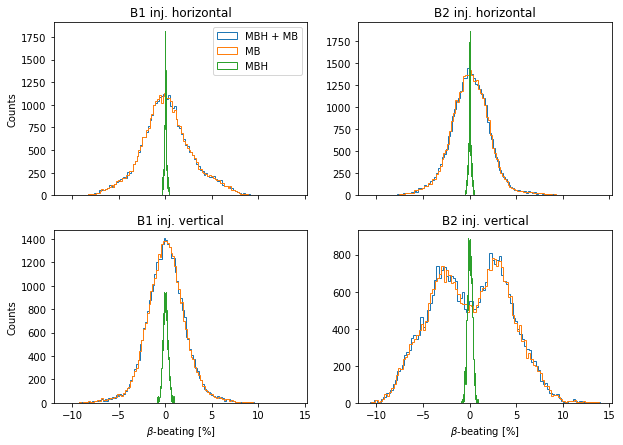

In [157]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, sharex=True,figsize=[10,7])

ax1.hist(bb11x*100,bins=100,histtype='step',label='MBH + MB')
ax1.hist(bb12x*100,bins=100,histtype='step',label='MB')
ax1.hist(bb13x*100,bins=100,histtype='step',label='MBH')
ax1.set_title('B1 inj. horizontal')
ax1.legend()

ax2.hist(bb21x*100,bins=100,histtype='step')
ax2.hist(bb22x*100,bins=100,histtype='step')
ax2.hist(bb23x*100,bins=100,histtype='step')
ax2.set_title('B2 inj. horizontal')

ax3.hist(bb11y*100,bins=100,histtype='step')
ax3.hist(bb12y*100,bins=100,histtype='step')
ax3.hist(bb13y*100,bins=100,histtype='step')
ax3.set_title('B1 inj. vertical')

ax4.hist(bb21y*100,bins=100,histtype='step')
ax4.hist(bb22y*100,bins=100,histtype='step')
ax4.hist(bb23y*100,bins=100,histtype='step')
ax4.set_title('B2 inj. vertical')


for ax in [ax3, ax4]:
    ax.set_xlabel(r'$\beta$-beating [%]')
    
for ax in [ax1, ax3]:
    ax.set_ylabel(r'Counts')

plt.show()

Perform some statistical analysis

In [173]:
description = ['B1 MBH+MB', 'B1 MB', 'B1 MBH', 'B2 MBH+MB', 'B2 MB', 'B2 MBH']
datasets    = [bb11x,bb12x,bb13x,bb21x,bb22x,bb23x]

for _i in range(len(description)):
    print(description[_i])
    print(datasets[_i].describe())
    print('')

B1 MBH+MB
count    32520.000000
mean         0.001390
std          0.027558
min         -0.090684
25%         -0.015647
50%          0.000087
75%          0.017340
max          0.109006
dtype: float64

B1 MB
count    32520.000000
mean         0.001370
std          0.027448
min         -0.090292
25%         -0.015562
50%          0.000105
75%          0.017286
max          0.108554
dtype: float64

B1 MBH
count    32520.000000
mean         0.000013
std          0.001289
min         -0.005243
25%         -0.000631
50%          0.000012
75%          0.000653
max          0.005207
dtype: float64

B2 MBH+MB
count    32520.000000
mean         0.000420
std          0.021828
min         -0.088412
25%         -0.012933
50%          0.000344
75%          0.013659
max          0.121516
dtype: float64

B2 MB
count    32520.000000
mean         0.000420
std          0.021648
min         -0.088392
25%         -0.012845
50%          0.000357
75%          0.013605
max          0.119794
dtype: float64

B

## Collision

In [174]:
bb11x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1col,'betx')
bb12x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1col,'betx')
bb13x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b1col,'betx')

bb11y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1col,'bety')
bb12y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b1col,'bety')
bb13y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B1_col_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b1col,'bety')

bb21x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2col,'betx')
bb22x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2col,'betx')
bb23x, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b2col,'betx')

bb21y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH1_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2col,'bety')
bb22y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH0_MB1_BPM_seed_{0}_ql_1.0000.tfs',b2col,'bety')
bb23y, _ = bb.get_bb_all_seeds(datadir+'HLLHC_B2_col_MBH1_MB0_BPM_seed_{0}_ql_1.0000.tfs',b2col,'bety')

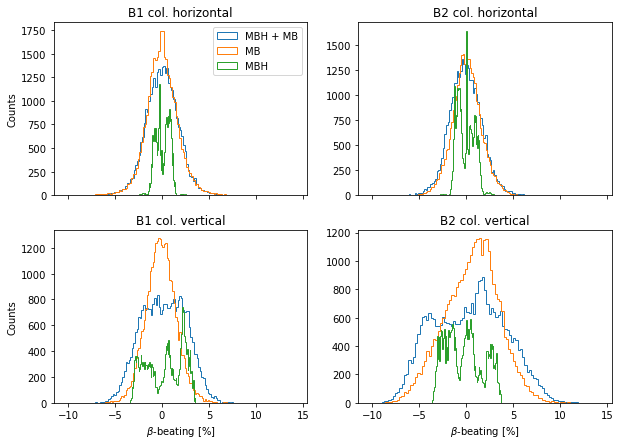

In [176]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, sharex=True,figsize=[10,7])

ax1.hist(bb11x*100,bins=100,histtype='step',label='MBH + MB')
ax1.hist(bb12x*100,bins=100,histtype='step',label='MB')
ax1.hist(bb13x*100,bins=100,histtype='step',label='MBH')
ax1.set_title('B1 col. horizontal')
ax1.legend()

ax2.hist(bb21x*100,bins=100,histtype='step')
ax2.hist(bb22x*100,bins=100,histtype='step')
ax2.hist(bb23x*100,bins=100,histtype='step')
ax2.set_title('B2 col. horizontal')

ax3.hist(bb11y*100,bins=100,histtype='step')
ax3.hist(bb12y*100,bins=100,histtype='step')
ax3.hist(bb13y*100,bins=100,histtype='step')
ax3.set_title('B1 col. vertical')

ax4.hist(bb21y*100,bins=100,histtype='step')
ax4.hist(bb22y*100,bins=100,histtype='step')
ax4.hist(bb23y*100,bins=100,histtype='step')
ax4.set_title('B2 col. vertical')


for ax in [ax3, ax4]:
    ax.set_xlabel(r'$\beta$-beating [%]')
    
for ax in [ax1, ax3]:
    ax.set_ylabel(r'Counts')

plt.show()

Here, the effect is stronger due to the larger $b_2$ field.

In [177]:
description = ['B1 MBH+MB', 'B1 MB', 'B1 MBH', 'B2 MBH+MB', 'B2 MB', 'B2 MBH']
datasets    = [bb11x,bb12x,bb13x,bb21x,bb22x,bb23x]

for _i in range(len(description)):
    print(description[_i])
    print(datasets[_i].describe())
    print('')

B1 MBH+MB
count    32520.000000
mean        -0.000033
std          0.017519
min         -0.084280
25%         -0.011410
50%         -0.000016
75%          0.011231
max          0.090376
dtype: float64

B1 MB
count    32520.000000
mean        -0.000455
std          0.016879
min         -0.088181
25%         -0.010722
50%         -0.000712
75%          0.009750
max          0.095208
dtype: float64

B1 MBH
count    27100.000000
mean         0.000508
std          0.007456
min         -0.027301
25%         -0.005613
50%          0.000262
75%          0.006924
max          0.028055
dtype: float64

B2 MBH+MB
count    32520.000000
mean        -0.001024
std          0.017032
min         -0.083104
25%         -0.012410
50%         -0.001474
75%          0.010072
max          0.083010
dtype: float64

B2 MB
count    32520.000000
mean         0.000163
std          0.015355
min         -0.075361
25%         -0.009578
50%         -0.000076
75%          0.009706
max          0.077088
dtype: float64

B